In [1]:
"""
All necessary imports
"""

import math
import csv

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.spatial.distance as distance
import scipy

from pandas import read_csv
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from minepy import MINE

import matplotlib.pyplot as plt
import seaborn
from mrmr import mrmr_classif
import pprint
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('magneticmoment_Ef_data.csv', header=0)
mine = MINE(alpha=0.6, c=15) #a=.6 recommended by paper, c of more than 15 has no change in result

In [3]:
tmp = []
for j in range(len(df.columns)):
    if( not (isinstance(df.iloc[0][j], np.float64) or isinstance(df.iloc[0][j], np.int64)) ):
        tmp.append(df.columns[j])

#print(tmp)
df = df.drop(columns=tmp)
df = df.drop(columns=['formation_energy'])
#df.head(2)

In [4]:
y_axis = "magnetic_moment"
MIC_corrs = []

for j in range(len(df.columns)):
    
    mine.compute_score(df.iloc[:,j],df[y_axis]) 
    tmp_corr = mine.mic() 

    colname = df.columns[j]

    MIC_corrs.append((colname, tmp_corr))

corrdf = pd.DataFrame.from_records(MIC_corrs[1:], columns=['feature', 'correlation'])
corrdf = corrdf.dropna()
corrdf = corrdf.sort_values(by=['correlation'])

mic_corrdf = corrdf.iloc[-13:-1]



mic_descriptors = list(mic_corrdf["feature"])
print(mic_descriptors)

['energy', 'covalentrad_max_dif', 'nvalence_std_dif', 'nvalence_sum_dif', 'dipole_avg', 'nvalence_max_dif', 'num_d', 'cmpd_sigma_d', 'Nup_mean', 'nvalence_std', 'nvalence_avg', 'cmpd_skew_d']


In [5]:
#remove what we want to predict
labels = np.array(df['magnetic_moment'])

df = df.drop(columns=['magnetic_moment'])

In [6]:
mrmr_candidates = corrdf.iloc[-60:-1]
mrmr_input = list(mrmr_candidates["feature"])

In [7]:


#make dataframes for mic top 12, paper top 12, total df
mic_descriptors = mic_descriptors
df_input = df[mrmr_input]
mrmr_descriptors = mrmr_classif(df_input, labels, K = 12)
paper_descriptors = ["Nup_mean", "cs_bob",  "nvalence_max_dif", "dipole_avg", 
                     "Nup_var", "nvalence_std", "nvalence_avg", "dipole_std_dif",  
                     "vdwradius_avg", "covalentrad_std_dif", "dipole_max_dif", "hardness_mean" ]

df_all = df
df_mic = df[mic_descriptors]
df_mrmr = df[mrmr_descriptors]
df_paper = df[paper_descriptors]

#----------------------------------------------------------------------
#get list of feature names for all, MIC top 12, paper top 12
#----------------------------------------------------------------------
feature_list_all = list(df_all.columns)

feature_list_mic = list(df_mic.columns)

feature_list_mrmr = list(df_mrmr.columns)

feature_list_paper = list(df_paper.columns)

#get numpy array of all, mic, and paper features
features_all   = np.array(df_all)
features_mic   = np.array(df_mic)
features_mrmr  = np.array(df_mrmr)
features_paper = np.array(df_paper)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 40.71it/s]


In [8]:
# Using Skicit-learn to split data into training and testing sets

# Split the data into training and testing sets

def make_train_test_split(features, labels):
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)
    return train_features, test_features, train_labels, test_labels 


In [9]:

def get_r_sq(predictions, test_labels):
    r_sq = metrics.r2_score(predictions, test_labels)
    return r_sq


In [10]:
def print_importances(rf, feature_list):
    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances 
    print("Most important variables:")
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:40]];

In [11]:

def make_graph(test_labels, predictions, r_sq, mode):
    x = test_labels
    y=predictions
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(predictions, test_labels)

    y2=(test_labels * slope + intercept)
    plt.scatter(x,y, color='c', label="data")
    plt.plot(x,y2, color='b', label="fitted line")

    plt.xlabel("True magnetic moment")
    plt.ylabel("Predicted")


    lab = "r^2=%.3f " % (r_sq)

    plt.plot([], [], ' ', label=lab )

    plt.legend()
    plt.title("Magnetic Moment predictions using {} descriptors".format(mode))
    plt.show()

In [12]:
def run_and_graph(labels, features, feature_list, mode, best_estimator, print_features=False):
    train_features, test_features, train_labels, test_labels = make_train_test_split(features, labels)
    
    rf = best_estimator
    # Train the model on training data
    #best_estimator.fit(test_features, test_labels)
    rf.fit(train_features, train_labels);
    predictions = rf.predict(test_features)
    r_sq = get_r_sq(predictions, test_labels)
    print("r squared value for", mode + ": ", round(r_sq, 2))
    if(print_features):
        print_importances(rf, feature_list)
    make_graph(test_labels,predictions, r_sq, mode)

In [13]:
""" hyperparameter tuning for random forest"""
# Number of trees in random forest
n_estimators = np.arange(10,200,10)
# Maximum number of levels in tree
max_depth = list(range(2,8))

params = {'n_estimators': n_estimators,
               'max_depth': max_depth}
pprint.pprint(params)

rf=RandomForestRegressor()

grid_rf = GridSearchCV(estimator = rf,
                        param_grid = params,
                        scoring = 'r2', 
                        cv = 5, 
                        verbose = 1,
                        n_jobs = -1)

train_features, test_features, train_labels, test_labels = make_train_test_split(features_mic, labels)

grid_rf.fit(train_features, train_labels)


{'max_depth': [2, 3, 4, 5, 6, 7],
 'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])}
Fitting 5 folds for each of 114 candidates, totalling 570 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
             scoring='r2', verbose=1)

In [14]:
# get best estimator
print(grid_rf.best_estimator_)
#pprint.pprint(test_labels)
print(grid_rf.score(test_features, test_labels))

RandomForestRegressor(max_depth=7, n_estimators=80)
0.8223753430263121


r squared value for MIC:  0.65


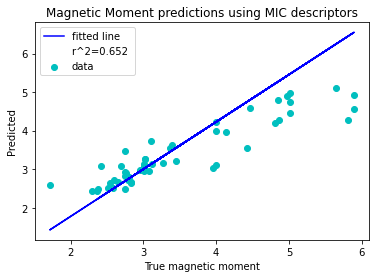

In [15]:
#run_and_graph(labels, features_all, feature_list_all, "All", print_features=False)
run_and_graph(labels, features_mic, feature_list_mic, "MIC", grid_rf.best_estimator_, print_features=False)
#run_and_graph(labels, features_mrmr, feature_list_mrmr, "mRMR", print_features=False)
#run_and_graph(labels, features_paper, feature_list_paper, "Paper", print_features=False)


In [16]:
#print this estimator



# X = test_features
# y = test_labels

# print(X.shape)
# print(y.shape)


# Predict the target variable
#y = best_estimator.predict(test_features)
# best_estimator = grid_rf.best_estimator_
# best_estimator.fit(train_features, train_labels)
# x = test_labels
# y=best_estimator.predict(test_features)
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y, x)


# y2=(test_labels * slope + intercept)
# plt.scatter(x,y, color='c', label="data")
# plt.plot(x,y2, color='b', label="fitted line")

# plt.xlabel("True magnetic moment")
# plt.ylabel("Predicted")

# r_sq = get_r_sq(y, x)
# lab = "r^2=%.3f " % (r_sq)

# plt.plot([], [], ' ', label=lab )

# plt.legend()
# plt.title("Magnetic Moment predictions using {} descriptors".format(mode))
# plt.show()


In [17]:
# hyperparameter tuning for MIC